# Retinal blood vessels detection
#### by Michał Pawlicki & Agnieszka Grzymska

## Image processing algorithm

### 1. Image preprocessing - histogram equalization

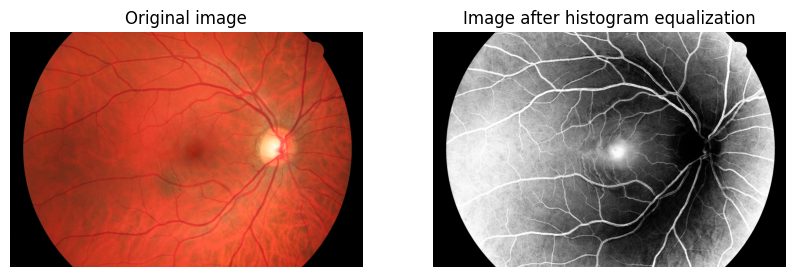

In [19]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.filters import hessian, frangi

def get_green_channel(img):
    _, green_img, _ = cv.split(img)
    green_img = invert_colors(green_img)
    return green_img

def invert_colors(img):
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = abs(255 - img[x][y])
    return new_image

images_paths = os.listdir('input/healthy/images')
images = []

for path in images_paths[:1]:
    initial_img = cv.imread("input/healthy/images/" + path, cv.IMREAD_COLOR)
    assert initial_img is not None, "file could not be read, check with os.path.exists()"
    initial_img = cv.cvtColor(initial_img, cv.COLOR_BGR2RGB)
    img_mask = cv.imread("input/healthy/masks/" + path[:-4] + "_mask.tif", cv.IMREAD_GRAYSCALE)
    img = get_green_channel(initial_img)
    result = cv.bitwise_and(img, img, mask=img_mask)
    equ = cv.equalizeHist(result)
    images.append(equ)

    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(initial_img)
axs[0].set_title('Original image')
axs[0].axis('off')
axs[1].imshow(cv.cvtColor(equ, cv.COLOR_BGR2RGB))
axs[1].set_title('Image after histogram equalization')
axs[1].axis('off')

plt.show()

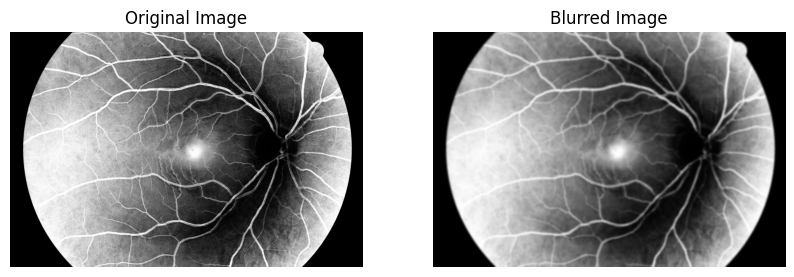

In [3]:
img = cv.GaussianBlur(equ, (51,51), 0)

# Display the original image and the blurred image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(equ, cmap='gray')
axs[0].set_title('Previous Image')
axs[0].axis('off')
axs[1].imshow(img, cmap='gray')
axs[1].set_title('Blurred Image')
axs[1].axis('off')

plt.show()

### 2. Proper processing - Hessian filter

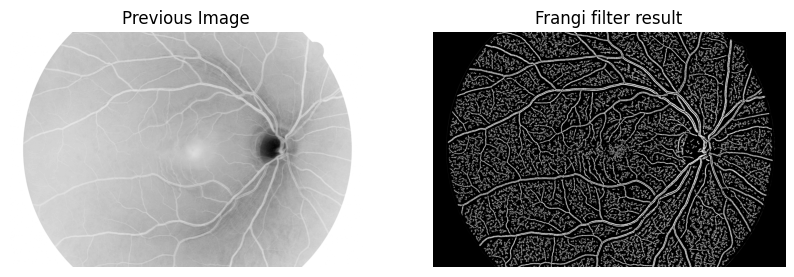

In [20]:
hes_img = hessian(img)
hes_img = cv.bitwise_and(hes_img, hes_img, mask=img_mask)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Previous Image')
axs[0].axis('off')
axs[1].imshow(hes_img, cmap='gray')
axs[1].set_title('Frangi filter result')
axs[1].axis('off')

plt.show()

### 3. Final image processing

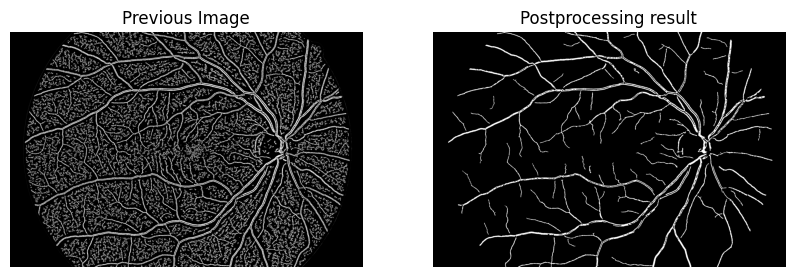

In [26]:
def noise_removing(img, min_size = 600):
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=8)
    sizes = stats[1:, -1]
    clear_img = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for i in range(0, nb_components - 1):
        if sizes[i] >= min_size:
            clear_img[output == i + 1] = 255
    return clear_img

def retina_circle_removing(img, base_offset=2000):
    no_retina_img = img.copy()
    circle = np.zeros(img.shape, np.uint8)
    offset = 0
    detections = []
    while True:
        detections = cv.HoughCircles(no_retina_img, cv.HOUGH_GRADIENT, 1.5, base_offset + offset)
        if detections is None:
            return no_retina_img
        if len(detections[0]) == 1:
            break
        offset += 100
    for (x, y, r) in detections[0]:
        cv.circle(circle, (int(x), int(y)), int(r), (255, 255, 255), 40)
    no_retina_img = no_retina_img - circle
    return no_retina_img


filtered_img = cv.bilateralFilter(np.uint8(hes_img),11,75,75)
result = noise_removing(filtered_img)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(hes_img, cmap='gray')
axs[0].set_title('Previous Image')
axs[0].axis('off')
axs[1].imshow(result, cmap='gray')
axs[1].set_title('Postprocessing result')
axs[1].axis('off')

plt.show()

### 4. Final results

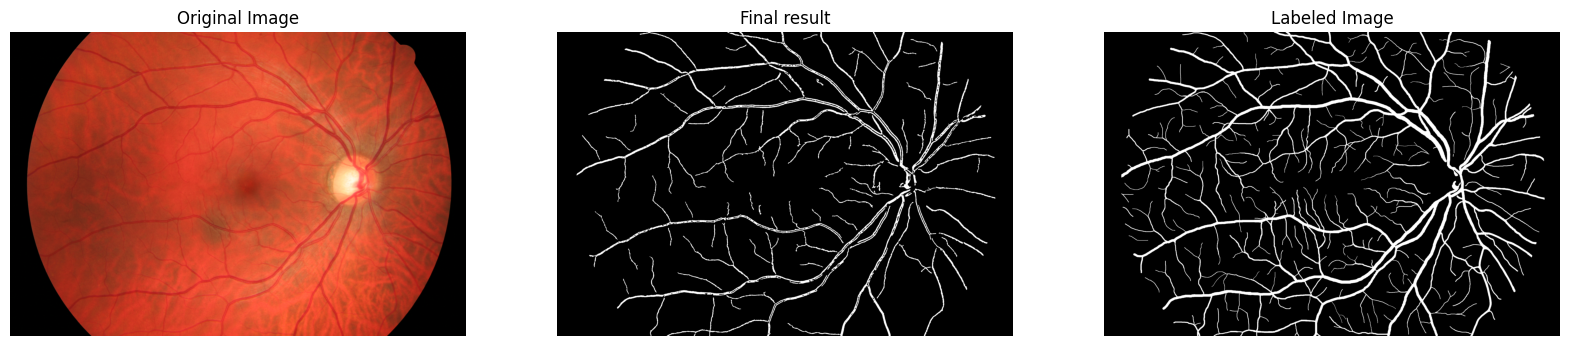

In [27]:
labeled_image = cv.imread("input/healthy/labeled_images/" + path[:-3] + "tif", cv.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(initial_img)
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(result, cmap='gray')
axs[1].set_title('Final result')
axs[1].axis('off')
axs[2].imshow(labeled_image, cmap='gray')
axs[2].set_title('Labeled Image')
axs[2].axis('off')

plt.show()

In [3]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

dataset_path = 'input/Train'
mask_set_path = 'input/Results'

input_size = (512, 512)

def load_data(dataset_path, mask_set_path):
    images = []
    masks = []
    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(dataset_path, filename)
            mask_path = os.path.join(mask_set_path, filename[:-3] + 'tif')
            image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
            image = cv.resize(image, input_size)
            mask = cv.resize(mask, input_size)
            images.append(image)
            masks.append(mask)
    return np.array(images), np.array(masks)

def preprocess_data(images, masks):
    images = images.astype('float32') / 255.0
    masks = masks.astype('float32') / 255.0
    masks = np.expand_dims(masks, axis=-1)
    return images, masks

images, masks = load_data(dataset_path, mask_set_path)

images, masks = preprocess_data(images, masks)

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_size + (1,)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='binary_crossentropy')

checkpoint = ModelCheckpoint('vessel_segmentation_model.h5', monitor='val_loss', save_best_only=True)

model.fit(train_images, train_masks, validation_data=(val_images, val_masks), batch_size=16, epochs=20, callbacks=[checkpoint])

Epoch 1/20
2/2 [==============================] - 11s 3s/step - loss: 0.6901 - val_loss: 0.6136
Epoch 2/20
2/2 [==============================] - 10s 3s/step - loss: 0.5942 - val_loss: 0.4539
Epoch 3/20
2/2 [==============================] - 10s 3s/step - loss: 0.4279 - val_loss: 0.3914
Epoch 4/20
2/2 [==============================] - 10s 3s/step - loss: 0.3809 - val_loss: 0.4579
Epoch 5/20
2/2 [==============================] - 10s 3s/step - loss: 0.4232 - val_loss: 0.3902
Epoch 6/20
2/2 [==============================] - 10s 3s/step - loss: 0.3608 - val_loss: 0.3433
Epoch 7/20
2/2 [==============================] - 10s 3s/step - loss: 0.3288 - val_loss: 0.3433
Epoch 8/20
2/2 [==============================] - 10s 3s/step - loss: 0.3299 - val_loss: 0.3256
Epoch 9/20
2/2 [==============================] - 10s 3s/step - loss: 0.3090 - val_loss: 0.3095
Epoch 10/20
2/2 [==============================] - 10s 3s/step - loss: 0.2931 - val_loss: 0.3123
Epoch 11/20
2/2 [======================

In [ ]:
from keras.models import load_model
import numpy as np
import cv2 as cv

model = load_model('vessel_segmentation_model.h5')

def preprocess_image(image):
    image = cv.resize(image, (512, 512))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

image_path = 'input/Test/03_h.jpg'
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

preprocessed_image = preprocess_image(image)
predicted_mask = model.predict(preprocessed_image)
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
predicted_mask = cv.morphologyEx(predicted_mask, cv.MORPH_CLOSE, kernel)


image = cv.resize(image, (512, 512))

vessels = cv.bitwise_and(image, image, mask=predicted_mask)

# Display the test image and the extracted vessels
cv.imshow('Test Image', image)
cv.imshow('Extracted Vessels', vessels)
cv.waitKey(0)
cv.destroyAllWindows()

